# Forecasting Net Pipeline Value
#### Aim : Apply different algorithms and choose the best one to predict the Net Pipeline Value on 1st October 2020

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.ar_model import AR,ARResults

from sklearn.metrics import r2_score
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

/home/shivangmathur/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/shivangmathur/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


#### Data Analysis and Data Processing

In [2]:
df = pd.read_excel('For Shivang Mathur.xlsx',parse_dates=True)

In [3]:
df = df[['pull_date','npv( Net Pipeline Value )']]

In [4]:
df

,pull_date,npv( Net Pipeline Value )
0,2020-07-03,24895276.32
1,2020-07-02,23111985.60
2,2020-07-01,23192385.60
3,2020-06-30,23350128.00
4,2020-06-29,23210928.00
...,...,...
597,2018-11-12,9340627.20
598,2018-10-28,8504467.20
599,2018-10-21,7462627.20
600,2018-10-14,6898027.20


In [5]:
df.sort_values(by=['pull_date'],inplace=True)

In [6]:
df.index = df['pull_date']
df = df[['npv( Net Pipeline Value )']]

In [7]:
all_days = pd.date_range(df.index.min(), df.index.max(), freq='D')
df=(df.reindex(all_days))
df=df.fillna(df.mean())

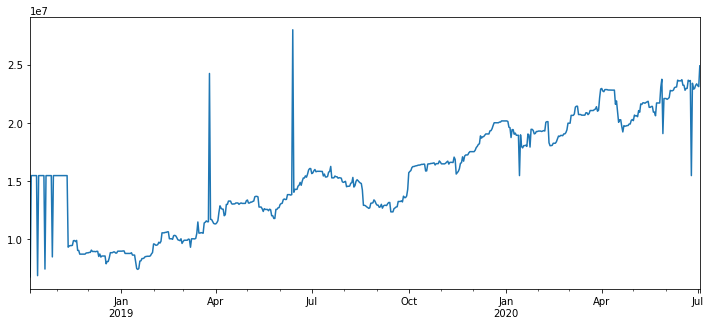

In [8]:
df['npv( Net Pipeline Value )'].plot(figsize=(12,5)).autoscale(axis='x',tight=True);

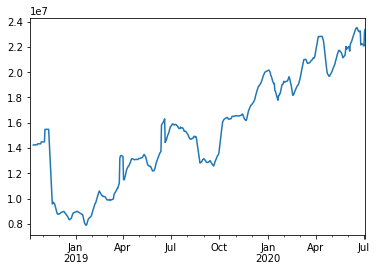

In [9]:
df.rolling(window=7).mean()['npv( Net Pipeline Value )'].plot();

In [10]:
#train-test split
train = df.iloc[:-60]
test = df.iloc[-60:]

We will check the performance of each algorithm on a validation set of 60 days.

### 1. Auto Regressive Model

In [11]:
model = AR(train['npv( Net Pipeline Value )'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const                           1.028558e+06
L1.npv( Net Pipeline Value )    9.305805e-01
dtype: float64


In [12]:
start=len(train)
end=len(train)+len(test)-1

In [13]:
rmse = []
model_name = []
predictions = AR1fit.predict(start=start, end=end, dynamic=False)
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], predictions)))
model_name.append('AR')

### 2. ARMA

In [14]:
model = ARMA(train['npv( Net Pipeline Value )'],order=(1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                 
=====================================================================================
Dep. Variable:     npv( Net Pipeline Value )   No. Observations:                  576
Model:                            ARMA(1, 1)   Log Likelihood               -8899.546
Method:                              css-mle   S.D. of innovations        1238031.130
Date:                       Wed, 26 Aug 2020   AIC                          17807.091
Time:                               01:43:48   BIC                          17824.516
Sample:                           10-07-2018   HQIC                         17813.887
                                - 05-04-2020                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.477e+07   2.72e+06      5.427      0.000    9.44e+06    2.01e+07
ar.L1.npv( Net Pipeline Value )     0.9954      0.004    271.498      0.000       0.988       1.003
ma.L1.npv( Net Pipeline Value )    -0.6864      0.031    -22.166      0.000      -0.747      -0.626
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0046           +0.0000j            1.0046            0.0000
MA.1            1.4569           +0.0000j            1.4569            0.0000
-----------------------------------------------------------------------------
"""

In [15]:
predictions = results.predict(start=start, end=end)
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], predictions)))
model_name.append('ARMA')

#### 3. SARIMAX

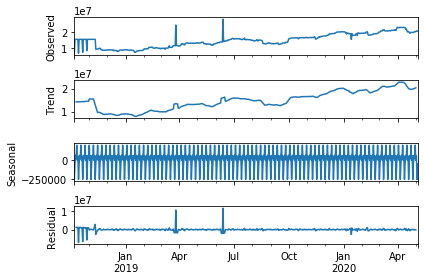

In [16]:
result = seasonal_decompose(train['npv( Net Pipeline Value )'])
result.plot();

In [17]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(train['npv( Net Pipeline Value )'],seasonal=True,m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  576
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 4)   Log Likelihood               -8918.543
Date:                           Wed, 26 Aug 2020   AIC                          17849.086
Time:                                   01:43:55   BIC                          17875.212
Sample:                                        0   HQIC                         17859.276
                                           - 576                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.192e+04   3.43e+04      0.638      0.523   -4.54e+04    8.92e+04
ar.L1          0.1111      0.026      4.293      0.000       0.060       0.162
ma.L1         -0.6846      0.025    -26.851      0.000      -0.735      -0.635
ar.S.L4       -0.8875      0.118     -7.549      0.000      -1.118      -0.657
ma.S.L4        0.8352      0.138      6.056      0.000       0.565       1.106
sigma2      1.464e+12      0.061   2.41e+13      0.000    1.46e+12    1.46e+12
===================================================================================
Ljung-Box (Q):                       69.51   Jarque-Bera (JB):             67013.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             3.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+27. Standard errors may be unstable.
"""

In [18]:
model = SARIMAX(train['npv( Net Pipeline Value )'],order=(1,1,1),seasonal_order=(1,0,1,4),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:         npv( Net Pipeline Value )   No. Observations:                  576
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 4)   Log Likelihood               -8919.108
Date:                           Wed, 26 Aug 2020   AIC                          17848.215
Time:                                   01:43:55   BIC                          17869.987
Sample:                               10-07-2018   HQIC                         17856.707
                                    - 05-04-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1073      0.026      4.131      0.000       0.056       0.158
ma.L1         -0.6795      0.025    -26.901      0.000      -0.729      -0.630
ar.S.L4       -0.8891      0.114     -7.809      0.000      -1.112      -0.666
ma.S.L4        0.8367      0.135      6.215      0.000       0.573       1.100
sigma2      1.464e+12   4.07e-13   3.59e+24      0.000    1.46e+12    1.46e+12
===================================================================================
Ljung-Box (Q):                       68.92   Jarque-Bera (JB):             67174.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             3.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.46e+39. Standard errors may be unstable.
"""

In [19]:
# Obtain predicted values

predictions = results.predict(start=start, end=end, dynamic=False)

In [20]:
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], predictions)))
model_name.append('SARIMAX')

#### 4. LSTM

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [22]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [23]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [24]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [26]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [30]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
558/558 [==============================] - 4s 7ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 2/20
558/558 [==============================] - 11s 19ms/step - loss: 0.0035 - val_loss: 0.0063
Epoch 3/20
558/558 [==============================] - 11s 19ms/step - loss: 0.0034 - val_loss: 0.0052


In [31]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [32]:
predictions = scaler.inverse_transform(test_predictions)

In [33]:
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], predictions)))
model_name.append('LSTM')

#### 5. Fb Prophet

In [34]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

Importing plotly failed. Interactive plots will not work.


In [35]:
dff = pd.DataFrame({'ds': df.index,'y':df['npv( Net Pipeline Value )']})
dff.reset_index(drop=True, inplace=True)

In [36]:
prediction_size = 60
train_df = dff[:-prediction_size]

In [37]:
m = Prophet(yearly_seasonality=True,daily_seasonality=True)
m.fit(train_df)

In [38]:
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

In [39]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))


In [40]:
cmp_df = make_comparison_dataframe(dff.tail(60), forecast.tail(60))


In [41]:
cmp_df

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-05-05,2.100916e+07,1.946736e+07,2.264119e+07,2.053332e+07
2020-05-06,2.093780e+07,1.932354e+07,2.261475e+07,2.105652e+07
2020-05-07,2.110570e+07,1.954786e+07,2.271428e+07,2.091732e+07
2020-05-08,2.088501e+07,1.921648e+07,2.242979e+07,2.162832e+07
2020-05-09,2.091554e+07,1.934928e+07,2.259644e+07,2.158032e+07
2020-05-10,2.049597e+07,1.890798e+07,2.209145e+07,2.172312e+07
2020-05-11,2.075778e+07,1.912961e+07,2.230519e+07,2.172312e+07
2020-05-12,2.082696e+07,1.930869e+07,2.235674e+07,2.168472e+07
2020-05-13,2.072521e+07,1.898400e+07,2.222624e+07,2.175432e+07


In [42]:
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], forecast.iloc[-60:]['yhat'])))
model_name.append('Fb Prophet')

#### 6. XgBoost with Fastai

In [43]:
train = dff.iloc[:-60]
test_xgb = dff.iloc[-60:]

In [44]:
y_train = pd.Series(list(train['y']))
y_test = (test_xgb['y'])

In [45]:
def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

In [46]:
import re
add_datepart(train, 'ds')
add_datepart(test_xgb, 'ds')

In [47]:
X_train =train.drop('y',axis=1)
X_test =test_xgb.drop('y',axis=1)

In [48]:
import xgboost as xgb
params = {
    'booster': 'gbtree', 
    'objective': 'reg:squarederror', # regression task
    'subsample': 0.7, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.7, # 89% of features used
    'eta': 0.05, 
    'max_depth': 5, 
    'gamma':2,
    'seed': 42} # for reproducible results


dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)


watchlist = [(dtrain, 'train'),(dtest,'test')]

xgb_model = xgb.train(params, dtrain, 12000,early_stopping_rounds = 200, evals = watchlist, verbose_eval = True)


[0]	train-rmse:1.4575e+07	test-rmse:2.13315e+07
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
[1]	train-rmse:1.38597e+07	test-rmse:2.03922e+07
[2]	train-rmse:1.3187e+07	test-rmse:1.94964e+07
[3]	train-rmse:1.25419e+07	test-rmse:1.86495e+07
[4]	train-rmse:1.19313e+07	test-rmse:1.7838e+07
[5]	train-rmse:1.13521e+07	test-rmse:1.70657e+07
[6]	train-rmse:1.08308e+07	test-rmse:1.65167e+07
[7]	train-rmse:1.03063e+07	test-rmse:1.58166e+07
[8]	train-rmse:9.80396e+06	test-rmse:1.51513e+07
[9]	train-rmse:9.33019e+06	test-rmse:1.44651e+07
[10]	train-rmse:8.87831e+06	test-rmse:1.38572e+07
[11]	train-rmse:8.44874e+06	test-rmse:1.32828e+07
[12]	train-rmse:8.04069e+06	test-rmse:1.26984e+07
[13]	train-rmse:7.65654e+06	test-rmse:1.21843e+07
[14]	train-rmse:7.28802e+06	test-rmse:1.16945e+07
[15]	train-rmse:6.94195e+06	test-rmse:1.11908e+07
[16]	train-rmse:6.61007e+06	test-rmse:1.07493e+07
[17]	train-rmse:6.2

[172]	train-rmse:279922	test-rmse:2.46139e+06
[173]	train-rmse:277623	test-rmse:2.46118e+06
[174]	train-rmse:276065	test-rmse:2.46042e+06
[175]	train-rmse:275735	test-rmse:2.45972e+06
[176]	train-rmse:274197	test-rmse:2.45969e+06
[177]	train-rmse:273527	test-rmse:2.46035e+06
[178]	train-rmse:270117	test-rmse:2.45911e+06
[179]	train-rmse:267913	test-rmse:2.45887e+06
[180]	train-rmse:267320	test-rmse:2.45854e+06
[181]	train-rmse:266659	test-rmse:2.45895e+06
[182]	train-rmse:264634	test-rmse:2.45911e+06
[183]	train-rmse:263283	test-rmse:2.45732e+06
[184]	train-rmse:262250	test-rmse:2.45618e+06
[185]	train-rmse:261863	test-rmse:2.45595e+06
[186]	train-rmse:261162	test-rmse:2.45653e+06
[187]	train-rmse:260501	test-rmse:2.45748e+06
[188]	train-rmse:258507	test-rmse:2.45867e+06
[189]	train-rmse:256735	test-rmse:2.45858e+06
[190]	train-rmse:255632	test-rmse:2.45754e+06
[191]	train-rmse:252275	test-rmse:2.45715e+06
[192]	train-rmse:251964	test-rmse:2.45491e+06
[193]	train-rmse:249903	test-rmse:

[351]	train-rmse:131124	test-rmse:2.48909e+06
[352]	train-rmse:130177	test-rmse:2.48865e+06
[353]	train-rmse:129897	test-rmse:2.49016e+06
[354]	train-rmse:129281	test-rmse:2.48982e+06
[355]	train-rmse:128898	test-rmse:2.48899e+06
[356]	train-rmse:128279	test-rmse:2.48896e+06
[357]	train-rmse:127724	test-rmse:2.48867e+06
[358]	train-rmse:127534	test-rmse:2.48788e+06
[359]	train-rmse:127235	test-rmse:2.48842e+06
[360]	train-rmse:126900	test-rmse:2.48743e+06
[361]	train-rmse:126744	test-rmse:2.48748e+06
[362]	train-rmse:126149	test-rmse:2.48687e+06
[363]	train-rmse:125260	test-rmse:2.48691e+06
[364]	train-rmse:124948	test-rmse:2.48745e+06
[365]	train-rmse:124642	test-rmse:2.4876e+06
[366]	train-rmse:123931	test-rmse:2.48794e+06
[367]	train-rmse:123739	test-rmse:2.48847e+06
[368]	train-rmse:123367	test-rmse:2.48868e+06
[369]	train-rmse:122789	test-rmse:2.48859e+06
[370]	train-rmse:122497	test-rmse:2.48964e+06
[371]	train-rmse:122043	test-rmse:2.48966e+06
[372]	train-rmse:121628	test-rmse:2

In [49]:
pred= xgb_model.predict(dtest)

In [50]:
rmse.append(sqrt(mean_squared_error(test['npv( Net Pipeline Value )'], pred)))
model_name.append('XgBoost with Fastai')

### Comparison and Results

In [51]:
comparison = pd.DataFrame({'Model Name':model_name,'Root Mean Square Error':rmse})
comparison

,Model Name,Root Mean Square Error
0,AR,6.616189e+06
1,ARMA,3.049735e+06
2,SARIMAX,2.270993e+06
3,LSTM,3.327936e+06
4,Fb Prophet,1.500789e+06
5,XgBoost with Fastai,2.490184e+06


In [52]:
comparison[comparison['Root Mean Square Error']==comparison['Root Mean Square Error'].min()]['Model Name']

4    Fb Prophet
Name: Model Name, dtype: object

On comparing the results of all the algorithms we can see that Fb Prophet has given the lowest RMSE on the validation set. Now, we will train the same algorithm on the whole data and calculate predictions for our desired date.

In [53]:
from datetime import date, timedelta
sdate = date(2020,7,3)   # start date
edate = date(2020,10,2)   # end date

ds = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

In [54]:
df_predictions = pd.DataFrame({'ds' : ds})

In [55]:
m = Prophet(yearly_seasonality=True,daily_seasonality=True)
m.fit(dff)

In [56]:
forecast = m.predict(df_predictions)

In [57]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-03,1.532900e+07,2.145670e+07,2.477048e+07,1.532900e+07,1.532900e+07,7.769867e+06,7.769867e+06,7.769867e+06,6.051961e+06,...,926.145816,926.145816,926.145816,1.716980e+06,1.716980e+06,1.716980e+06,0.0,0.0,0.0,2.309886e+07
1,2020-07-04,1.534193e+07,2.161025e+07,2.469182e+07,1.534193e+07,1.534193e+07,7.802026e+06,7.802026e+06,7.802026e+06,6.051961e+06,...,63181.690697,63181.690697,63181.690697,1.686883e+06,1.686883e+06,1.686883e+06,0.0,0.0,0.0,2.314396e+07
2,2020-07-05,1.535486e+07,2.112437e+07,2.424466e+07,1.535486e+07,1.535486e+07,7.422186e+06,7.422186e+06,7.422186e+06,6.051961e+06,...,-288894.277909,-288894.277909,-288894.277909,1.659119e+06,1.659119e+06,1.659119e+06,0.0,0.0,0.0,2.277705e+07
3,2020-07-06,1.536779e+07,2.160597e+07,2.473067e+07,1.536779e+07,1.536779e+07,7.675636e+06,7.675636e+06,7.675636e+06,6.051961e+06,...,-10123.730650,-10123.730650,-10123.730650,1.633799e+06,1.633799e+06,1.633799e+06,0.0,0.0,0.0,2.304343e+07
4,2020-07-07,1.538072e+07,2.160343e+07,2.469533e+07,1.538072e+07,1.538072e+07,7.745601e+06,7.745601e+06,7.745601e+06,6.051961e+06,...,82748.121126,82748.121126,82748.121126,1.610892e+06,1.610892e+06,1.610892e+06,0.0,0.0,0.0,2.312633e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2020-09-27,1.644114e+07,1.844582e+07,2.212170e+07,1.583303e+07,1.709922e+07,3.735724e+06,3.735724e+06,3.735724e+06,6.051961e+06,...,-288894.277909,-288894.277909,-288894.277909,-2.027342e+06,-2.027342e+06,-2.027342e+06,0.0,0.0,0.0,2.017686e+07
87,2020-09-28,1.645407e+07,1.874719e+07,2.240428e+07,1.583168e+07,1.712433e+07,4.149454e+06,4.149454e+06,4.149454e+06,6.051961e+06,...,-10123.730650,-10123.730650,-10123.730650,-1.892384e+06,-1.892384e+06,-1.892384e+06,0.0,0.0,0.0,2.060352e+07
88,2020-09-29,1.646700e+07,1.905643e+07,2.250395e+07,1.582786e+07,1.715037e+07,4.378191e+06,4.378191e+06,4.378191e+06,6.051961e+06,...,82748.121125,82748.121125,82748.121125,-1.756518e+06,-1.756518e+06,-1.756518e+06,0.0,0.0,0.0,2.084519e+07
89,2020-09-30,1.647993e+07,1.921767e+07,2.274256e+07,1.583394e+07,1.717991e+07,4.467434e+06,4.467434e+06,4.467434e+06,6.051961e+06,...,36135.224243,36135.224243,36135.224243,-1.620662e+06,-1.620662e+06,-1.620662e+06,0.0,0.0,0.0,2.094737e+07


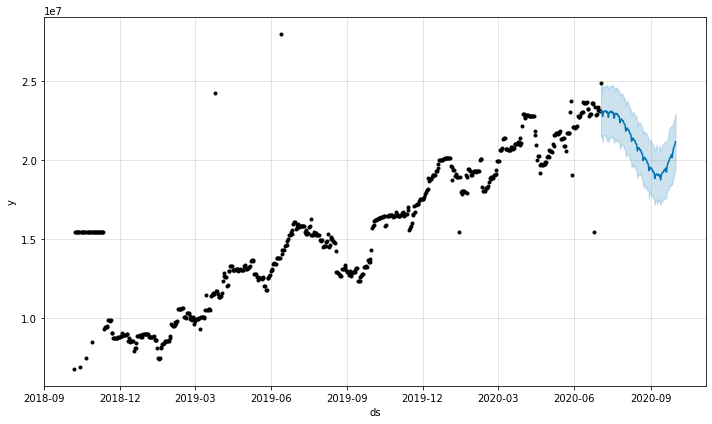

In [58]:
m.plot(forecast);

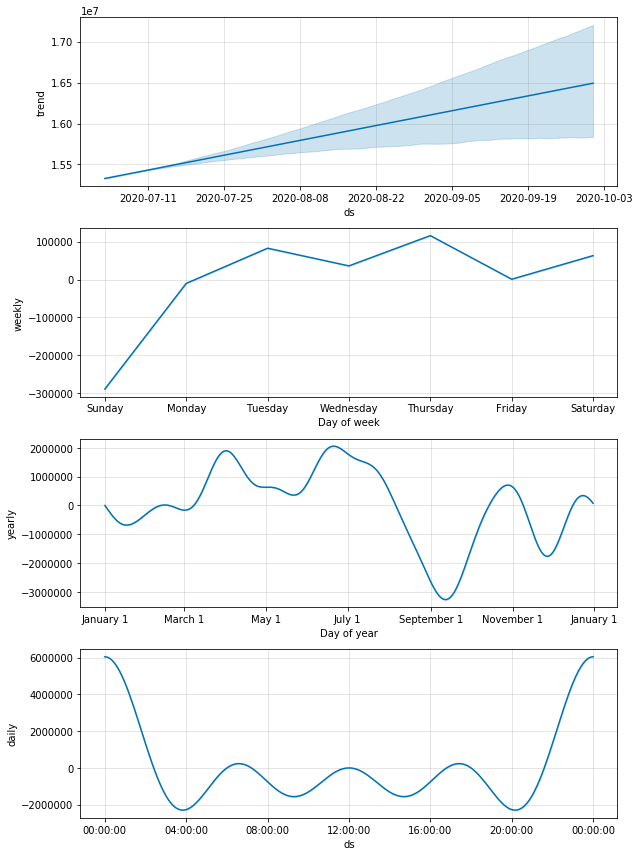

In [59]:
m.plot_components(forecast);

In [60]:
print("The value of Predicted PPV on 1st October 2020 is:",forecast.iloc[-1]['yhat'])

The value of Predicted PPV on 1st October 2020 is: 21175200.214999557
